In [90]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import json

In [91]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [92]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [93]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [94]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [95]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [96]:
type(test_images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [97]:
len(train_images)

3680

In [98]:
len(test_images)

3669

In [99]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [100]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [101]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Исходное изображение', 'Истинная маска', 'Предсказанная маска']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

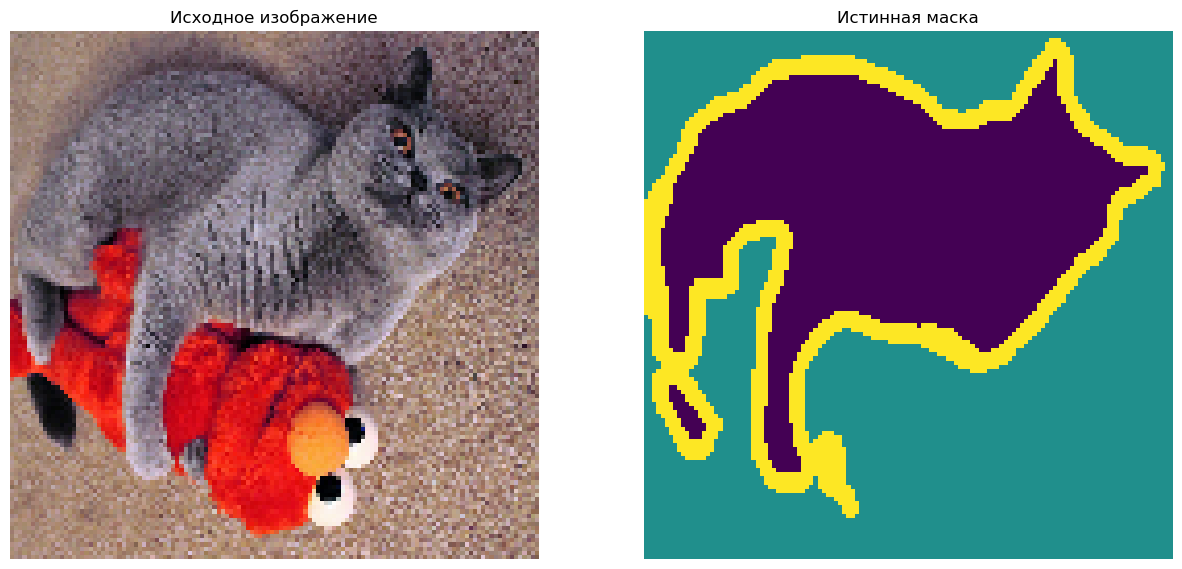

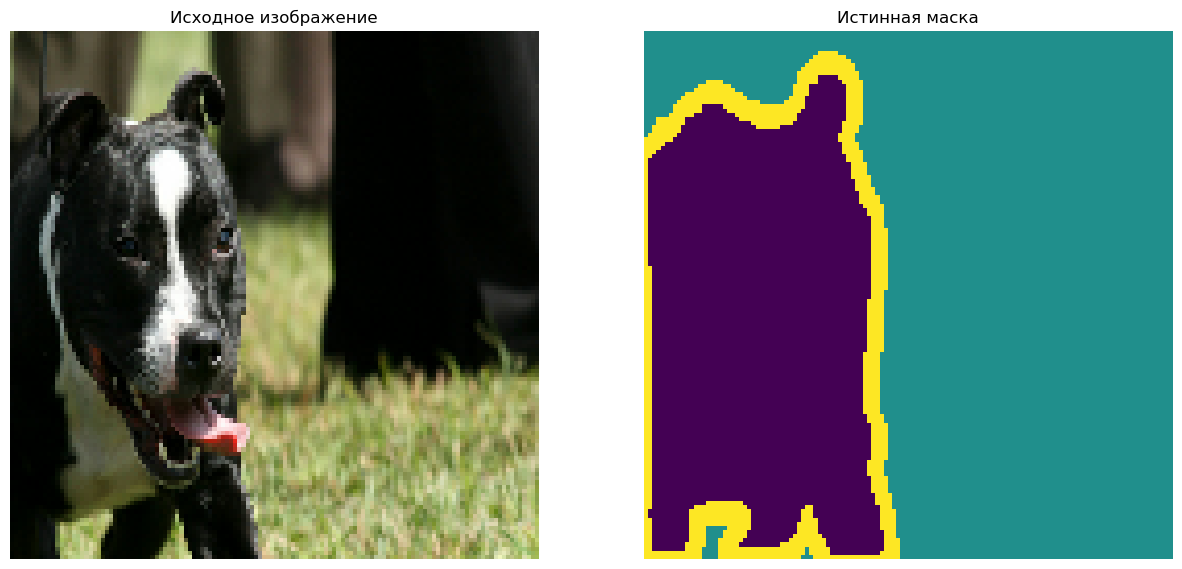

In [102]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [103]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',  # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [104]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]

In [105]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [106]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [107]:
OUTPUT_CLASSES = 3

try:
    model = tf.keras.models.load_model('saved_model/my_model')
except:
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    EPOCHS = 20
    VAL_SUBSPLITS = 5
    VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

    model_history = model.fit(train_batches, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,
                              callbacks=[DisplayCallback()])


    model.save('saved_model/my_model')
    history_dict = model_history.history
    json.dump(history_dict, open("saved_model/history.json", 'w'))

In [108]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [109]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


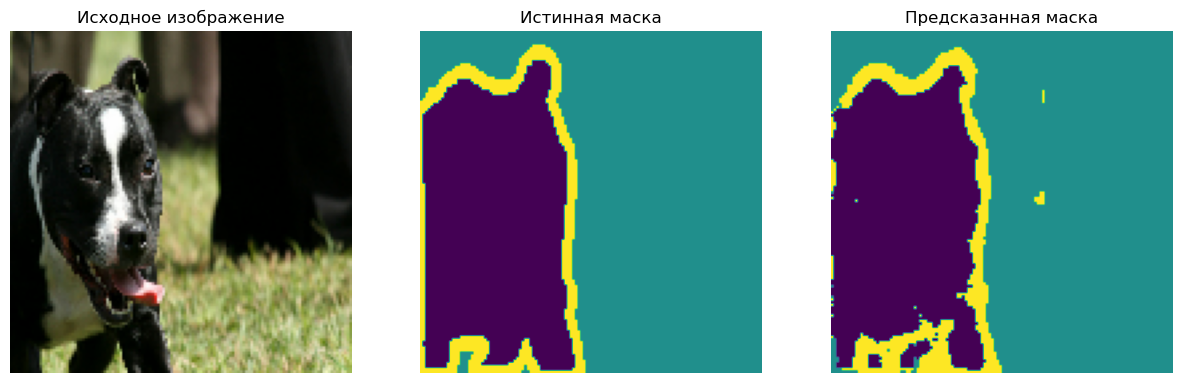

In [110]:
show_predictions()

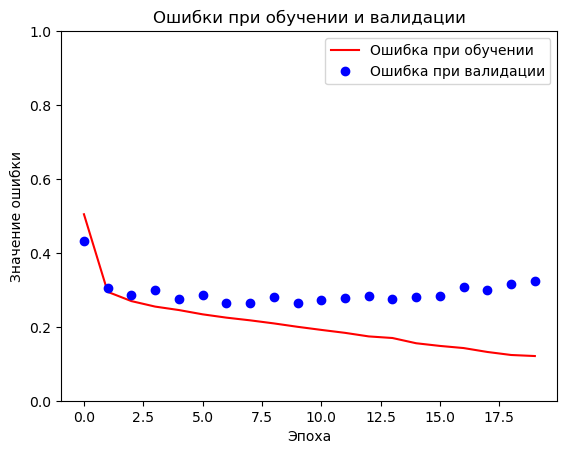

In [111]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Ошибка при обучении')
plt.plot(model_history.epoch, val_loss, 'bo', label='Ошибка при валидации')
plt.title('Ошибки при обучении и валидации')
plt.xlabel('Эпоха')
plt.ylabel('Значение ошибки')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 1s 340ms/step


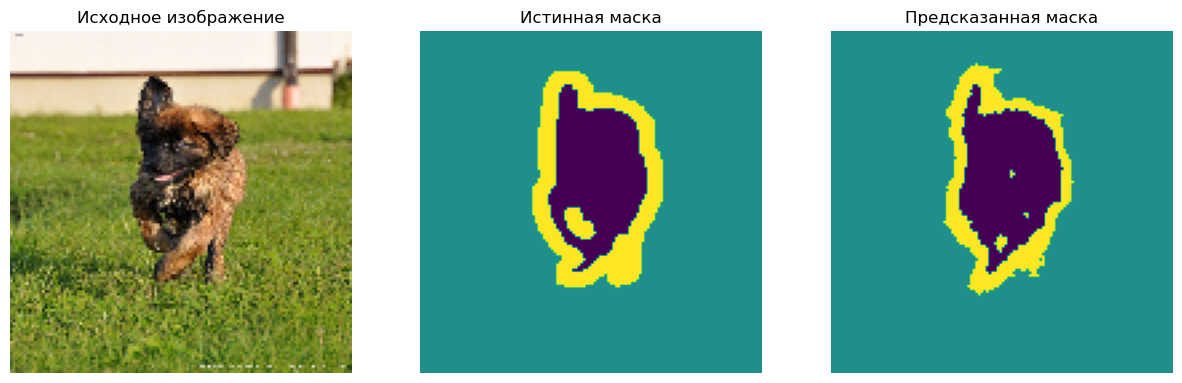

2/2 [==============================] - 1s 294ms/step


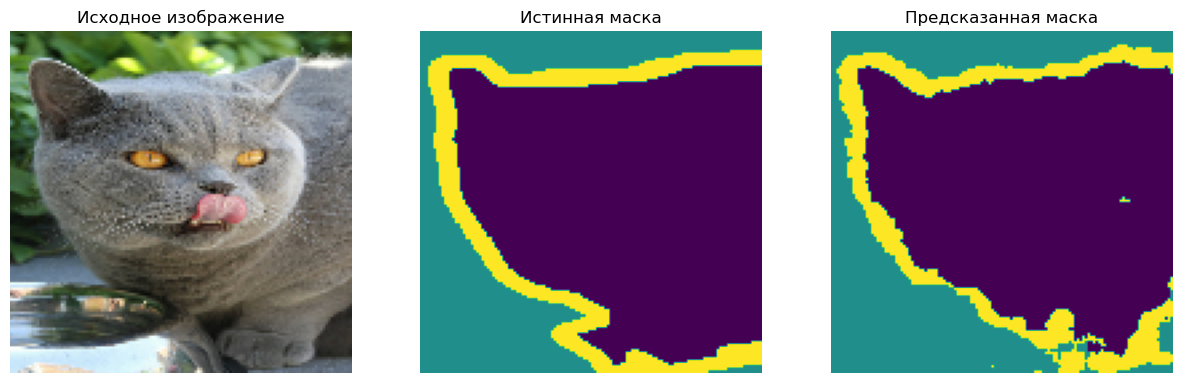

2/2 [==============================] - 1s 281ms/step


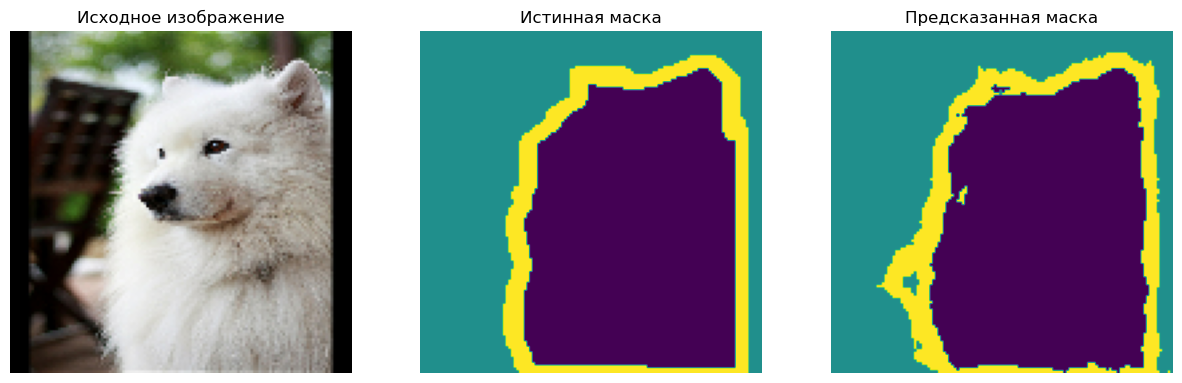

In [112]:
show_predictions(test_batches, 3)

In [113]:
another_dataset, another_info = tfds.load('oxford_flowers102:2.*.*', with_info=True)

In [114]:
def another_load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))

    input_image = another_normalize(input_image)

    return input_image

In [115]:
def another_normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [116]:
another_test_images = another_dataset['test'].map(another_load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [117]:
def another_show_predictions(dataset=None, num=1):
    if dataset:
        for image in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], create_mask(pred_mask)])
    else:
        display([sample_image,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 1s 304ms/step


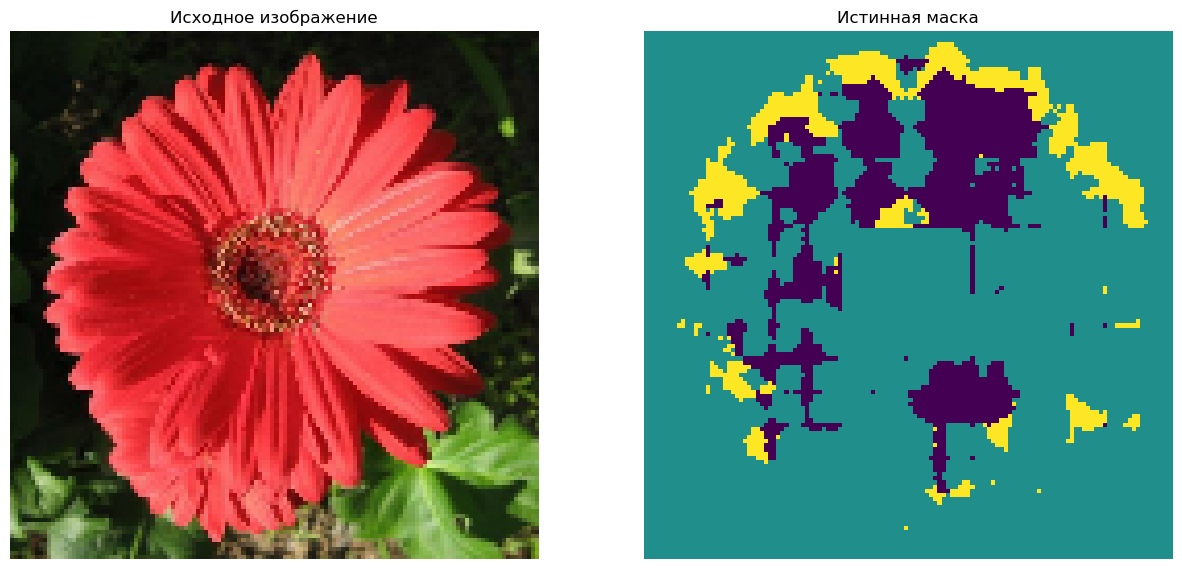

2/2 [==============================] - 1s 321ms/step


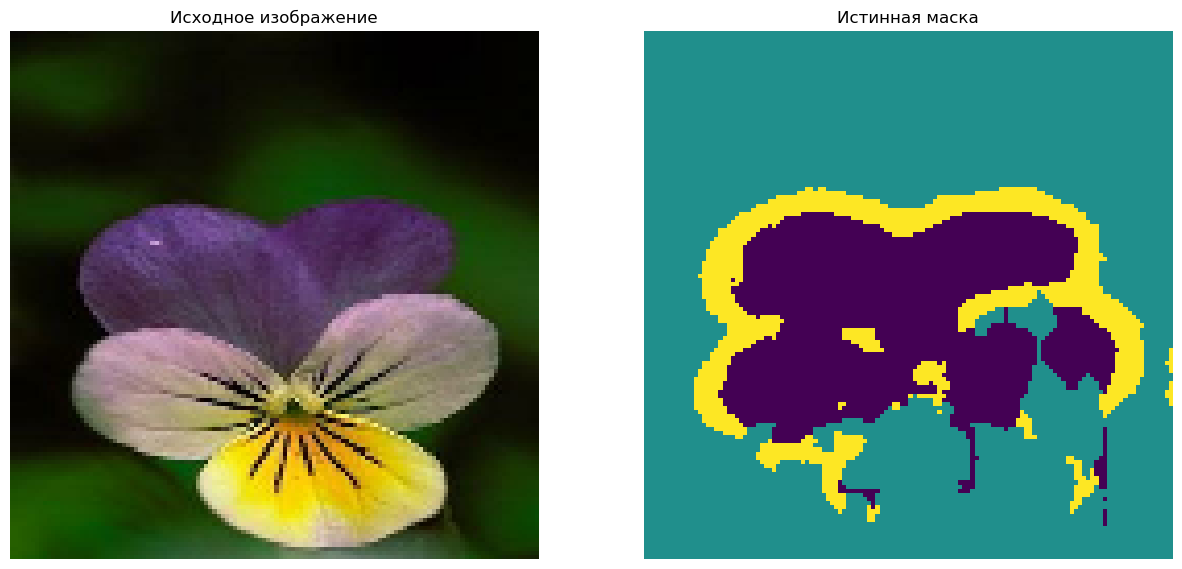

2/2 [==============================] - 1s 340ms/step


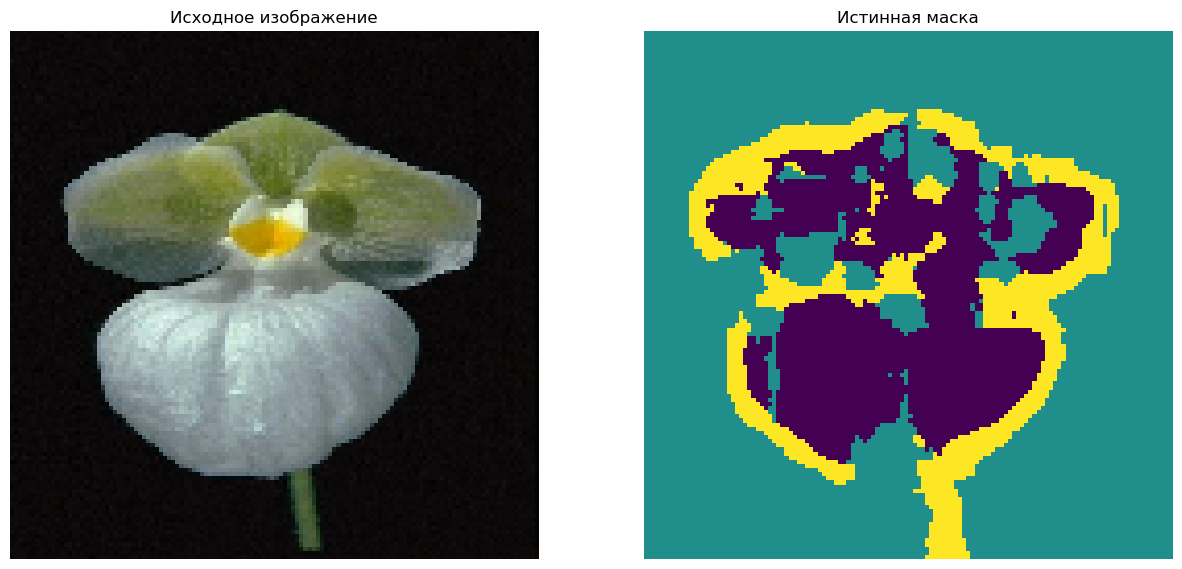

2/2 [==============================] - 1s 328ms/step


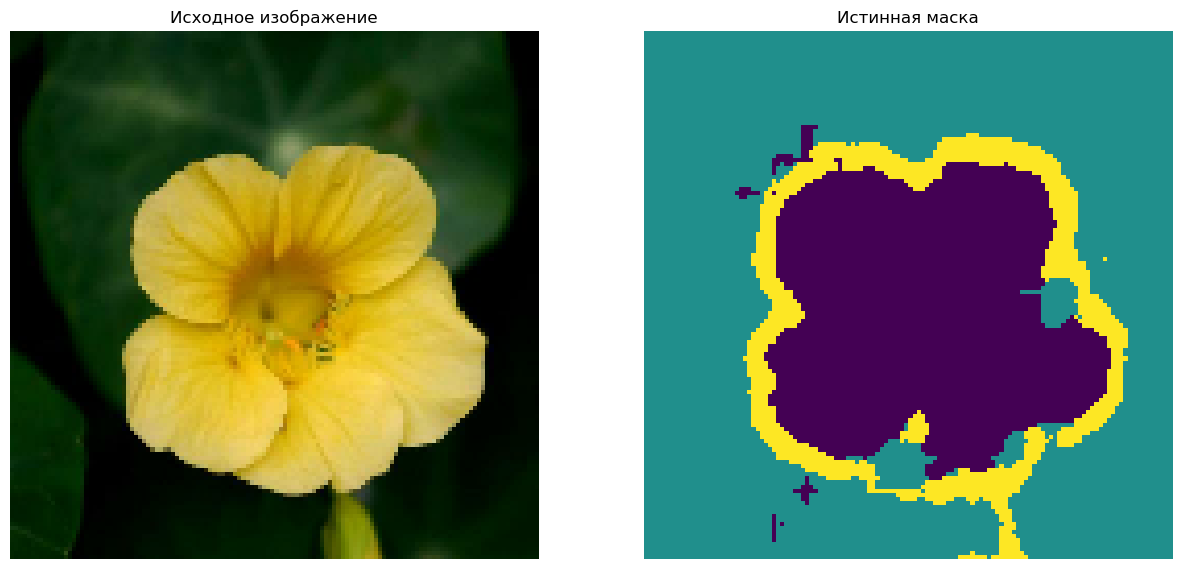

2/2 [==============================] - 1s 308ms/step


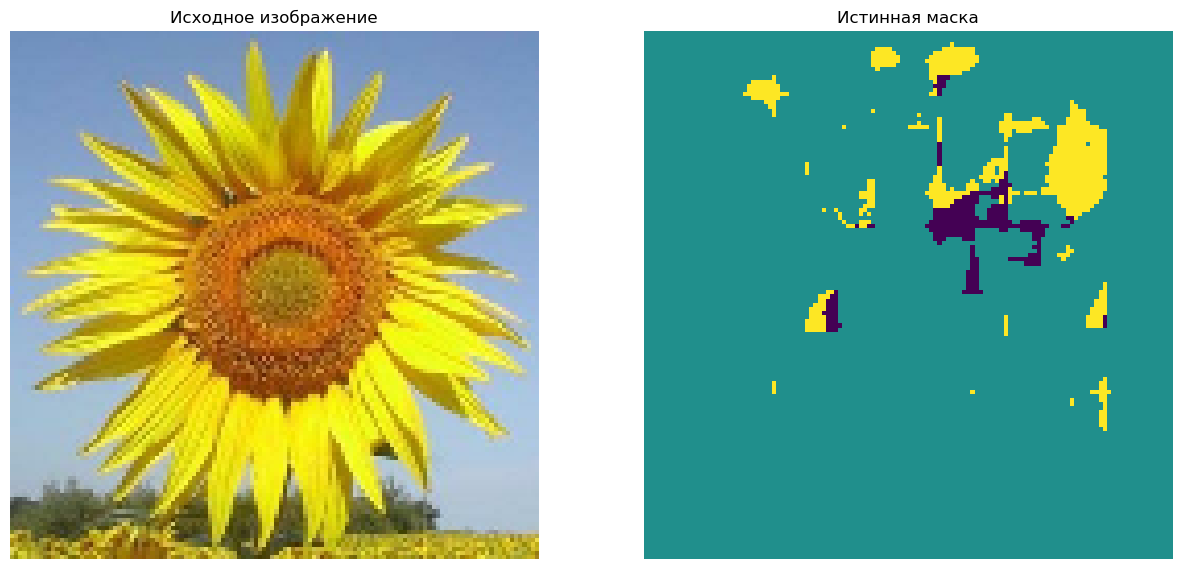

2/2 [==============================] - 1s 372ms/step


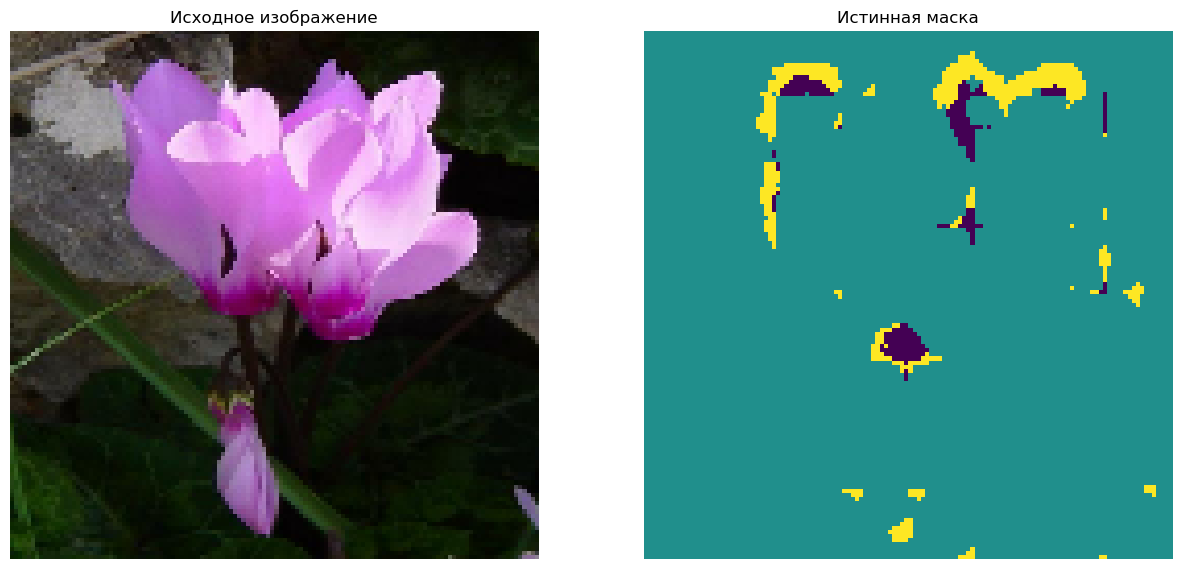

2/2 [==============================] - 1s 371ms/step


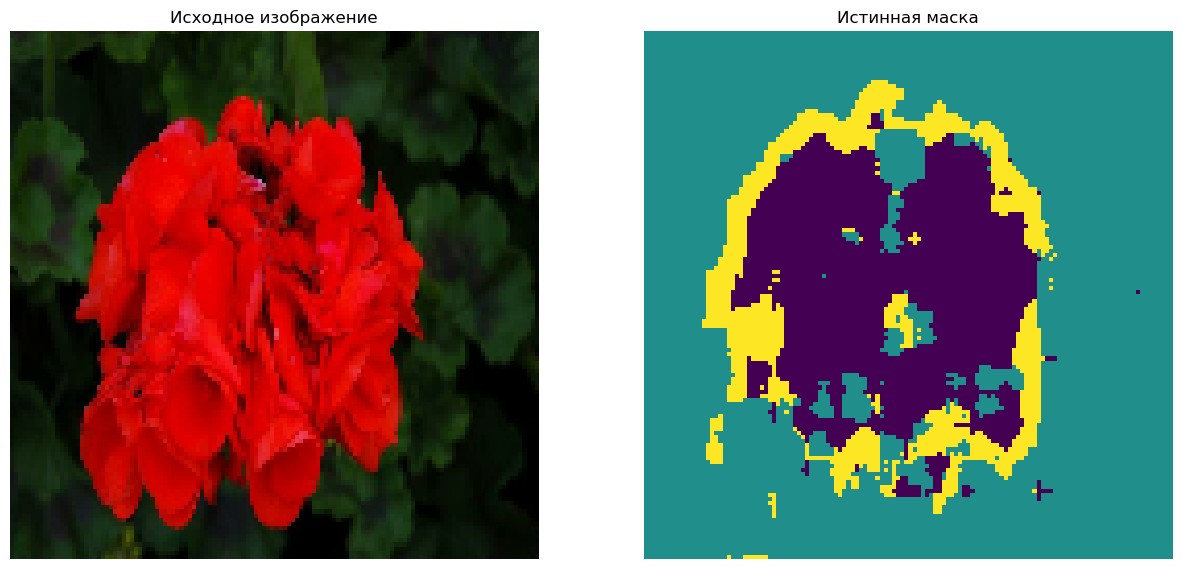

In [119]:
another_test_batches = another_test_images.batch(BATCH_SIZE)
another_show_predictions(another_test_batches, 7)